In [1]:
import pandas as pd
import os
from dotenv import load_dotenv

# Import LangChain's ChatOpenAI
from langchain.chat_models import ChatOpenAI
from langchain.schema import SystemMessage, HumanMessage

# Load OpenAI API key from .env file
if not load_dotenv():
    raise Exception('Error loading .env file. Make sure to place a valid OPENAI_API_KEY in the .env file.')

api_key = os.getenv("OPENAI_API_KEY")
if not api_key:
    raise Exception('Error loading OPENAI_API_KEY from .env file. Make sure to place a valid OPENAI_API_KEY in the .env file.')

# Initialize the ChatOpenAI object
chat = ChatOpenAI(temperature=0, openai_api_key=api_key)

/var/folders/bn/myxhlqpn24j6l21cwwcjgplc0000gn/T/ipykernel_16316/543355065.py:18: LangChainDeprecationWarning: The class `ChatOpenAI` was deprecated in LangChain 0.0.10 and will be removed in 1.0. An updated version of the class exists in the :class:`~langchain-openai package and should be used instead. To use it run `pip install -U :class:`~langchain-openai` and import as `from :class:`~langchain_openai import ChatOpenAI``.
  chat = ChatOpenAI(temperature=0, openai_api_key=api_key)


In [2]:

def convert_units(df):
    """
    Converts values in the DataFrame to a canonical unit per metric, considering the units present.
    Also determines the direction of the metric regarding sustainability (-1, 0, or 1).

    Parameters:
    df (pd.DataFrame): DataFrame containing at least the columns 'Metric', 'Value', 'Unit'.

    Returns:
    pd.DataFrame: DataFrame with new columns 'Converted Value', 'Canonical Unit', and 'Direction'.
    """
    # Initialize dictionaries to store canonical units, conversion factors, and directions
    canonical_units = {}
    unit_conversion_factors = {}
    metric_directions = {}

    # Determine canonical units, build conversion factors, and determine directions
    for metric in df['Metric'].unique():
        # Get the list of units for the current metric
        units = df[df['Metric'] == metric]['Unit'].unique().tolist()
        # Get the canonical unit for the metric using the LLM, considering the units present
        canonical_unit = get_canonical_unit(metric, units)
        if not canonical_unit:
            print(f"Could not determine canonical unit for metric '{metric}'. Skipping.")
            continue
        canonical_units[metric] = canonical_unit
        unit_conversion_factors[metric] = {}
        for unit in units:
            if unit == canonical_unit:
                unit_conversion_factors[metric][unit] = 1.0
            else:
                factor = get_conversion_factor(unit, canonical_unit)
                if factor:
                    unit_conversion_factors[metric][unit] = factor
                else:
                    # Handle cases where conversion factor could not be retrieved
                    unit_conversion_factors[metric][unit] = None  # Indicate failure to convert

        # Get the direction of the metric regarding sustainability
        direction = get_metric_direction(metric)
        if direction is not None:
            metric_directions[metric] = direction
        else:
            metric_directions[metric] = 0  # Default to neutral if unable to determine

    # Function to convert values to canonical units
    def convert_value(row):
        metric = row['Metric']
        unit = row['Unit']
        value = row['Value']
        factor = unit_conversion_factors.get(metric, {}).get(unit)
        if factor is None:
            # Unable to convert; return None or handle as needed
            print(f"Unable to convert '{unit}' to '{canonical_units.get(metric)}' for metric '{metric}'.")
            return None
        return value * factor

    # Apply the conversion to the DataFrame
    df['Canonical Unit'] = df['Metric'].map(canonical_units)
    df['Converted Value'] = df.apply(convert_value, axis=1)
    df['Direction'] = df['Metric'].map(metric_directions)

    return df

def get_canonical_unit(metric, units):
    """
    Uses the LLM to determine the most appropriate canonical unit for a given metric, considering the units present.

    Parameters:
    metric (str): The name of the metric.
    units (list): List of units present for the metric.

    Returns:
    str: The canonical unit.
    """
    units_list = ', '.join(units)
    prompt = (
        f"For the metric '{metric}', considering the units '{units_list}', "
        f"what is the most appropriate unit to standardize on for comparison purposes? "
        f"Choose one of the provided units or suggest a compatible unit. Provide only the unit name."
    )
    messages = [
        SystemMessage(content="You are an expert in units of measurement. When asked, you provide only the most appropriate unit to standardize on for a given metric, considering the units provided, as a single word or phrase, nothing else."),
        HumanMessage(content=prompt)
    ]
    try:
        response = chat(messages)
        answer = response.content.strip()
        print(f"Canonical unit for metric '{metric}': {answer}")
        return answer
    except Exception as e:
        print(f"Error getting canonical unit for metric '{metric}': {e}")
        return None

def get_conversion_factor(source_unit, target_unit):
    """
    Uses the LLM to get the conversion factor from source_unit to target_unit.

    Parameters:
    source_unit (str): The unit to convert from.
    target_unit (str): The unit to convert to.

    Returns:
    float: The conversion factor.
    """
    prompt = f"What is the numerical conversion factor to convert '{source_unit}' to '{target_unit}'? Provide only the numerical conversion factor."
    messages = [
        SystemMessage(content="You are an expert in unit conversions. When asked, you provide only the numerical conversion factor as a single number, nothing else."),
        HumanMessage(content=prompt)
    ]
    try:
        response = chat(messages)
        answer = response.content.strip()
        # Remove commas from numbers to handle thousands separators
        answer = answer.replace(',', '')
        factor = float(answer)
        print(f"Conversion factor from '{source_unit}' to '{target_unit}': {factor}")
        return factor
    except Exception as e:
        print(f"Error getting conversion factor from '{source_unit}' to '{target_unit}': {e}")
        return None

def get_metric_direction(metric):
    """
    Uses the LLM to determine whether, for the given metric, a higher value is better, a lower value is better, or neutral in terms of sustainability.

    Parameters:
    metric (str): The name of the metric.

    Returns:
    int: Direction indicator (-1 for lower is better, 1 for higher is better, 0 for neutral).
    """
    prompt = (
        f"In terms of sustainability, for the metric '{metric}', is a higher value better, a lower value better, or is it neutral? "
        f"Please respond with '-1' if a lower value is better, '1' if a higher value is better, or '0' if it's neutral. Provide only the number."
    )
    messages = [
        SystemMessage(content="You are an expert in sustainability metrics. When asked about a metric, you provide only the direction indicator as a single number: '-1' if a lower value is better, '1' if a higher value is better, or '0' if it's neutral."),
        HumanMessage(content=prompt)
    ]
    try:
        response = chat(messages)
        answer = response.content.strip()
        # Ensure the answer is one of -1, 0, or 1
        if answer in ['-1', '0', '1']:
            direction = int(answer)
            print(f"Direction for metric '{metric}': {direction}")
            return direction
        else:
            print(f"Invalid direction response for metric '{metric}': {answer}")
            return None
    except Exception as e:
        print(f"Error getting direction for metric '{metric}': {e}")
        return None

In [3]:
esg_metrics_small = [
    'Carbon Emissions',
    'Energy Consumption',
    'Water Usage',
    'Waste Generation',
    'Renewable Energy Usage',
    'Greenhouse Gas Emissions Intensity',
    'Biodiversity Impact',
]

In [4]:
import pandas as pd
import numpy as np


np.random.seed(420)

# Recreate the dummy data
thomas_data = {
    'Company': np.random.choice(['Apple', 'BP', 'Walmart', 'H&M', 'Google', 'Microsoft', 'Tesla', 'Unilever'], size=20),
    'Year': np.random.choice([2017, 2019, 2021, 2023], size=20),
    'Metric': np.random.choice(esg_metrics_small, size=20, replace=True),
    'Value': np.random.uniform(100, 10000, size=20, ),
    'Unit': np.random.choice(['tonnes', 'kg', 'kilotonnes', 'gramm'], size=20)
}

# Create a dataframe
thomas_df = pd.DataFrame(thomas_data)

In [5]:
df_converted_thomas = convert_units(thomas_df)

/var/folders/bn/myxhlqpn24j6l21cwwcjgplc0000gn/T/ipykernel_16316/4006267452.py:87: LangChainDeprecationWarning: The method `BaseChatModel.__call__` was deprecated in langchain-core 0.1.7 and will be removed in 1.0. Use :meth:`~invoke` instead.
  response = chat(messages)


Canonical unit for metric 'Greenhouse Gas Emissions Intensity': kilogram
Conversion factor from 'gramm' to 'kilogram': 0.001
Direction for metric 'Greenhouse Gas Emissions Intensity': -1
Canonical unit for metric 'Energy Consumption': tonnes
Conversion factor from 'kilotonnes' to 'tonnes': 1000.0
Conversion factor from 'gramm' to 'tonnes': 1e-06
Direction for metric 'Energy Consumption': -1
Canonical unit for metric 'Renewable Energy Usage': tonnes
Conversion factor from 'kg' to 'tonnes': 0.001
Conversion factor from 'kilotonnes' to 'tonnes': 1000.0
Direction for metric 'Renewable Energy Usage': 1
Canonical unit for metric 'Carbon Emissions': kilotonnes
Conversion factor from 'gramm' to 'kilotonnes': 1e-09
Conversion factor from 'kg' to 'kilotonnes': 0.001
Direction for metric 'Carbon Emissions': -1
Canonical unit for metric 'Waste Generation': kilotonnes
Conversion factor from 'kg' to 'kilotonnes': 0.001
Direction for metric 'Waste Generation': -1
Canonical unit for metric 'Biodiversi

In [6]:
df_converted_thomas

,Company,Year,Metric,Value,Unit,Canonical Unit,Converted Value,Direction
0,BP,2021,Greenhouse Gas Emissions Intensity,3888.254991,gramm,kilogram,3.888255e+00,-1
1,Apple,2017,Energy Consumption,3639.937816,kilotonnes,tonnes,3.639938e+06,-1
2,Tesla,2019,Renewable Energy Usage,7765.006995,tonnes,tonnes,7.765007e+03,1
3,Unilever,2019,Carbon Emissions,6661.502622,gramm,kilotonnes,6.661503e-06,-1
4,Unilever,2019,Energy Consumption,5080.660278,tonnes,tonnes,5.080660e+03,-1
5,H&M,2019,Waste Generation,9806.943807,kilotonnes,kilotonnes,9.806944e+03,-1
6,Tesla,2023,Waste Generation,3428.919967,kg,kilotonnes,3.428920e+00,-1
7,BP,2017,Renewable Energy Usage,4733.134841,tonnes,tonnes,4.733135e+03,1
8,Walmart,2017,Carbon Emissions,1248.037638,kg,kilotonnes,1.248038e+00,-1
9,Walmart,2023,Energy Consumption,6369.668338,gramm,tonnes,6.369668e-03,-1


In [10]:
import pandas as pd

def process_data(wanted_metric, df):
    # Step 1: Filter rows where 'Metric' equals 'wanted_metric'
    df_filtered = df[df['Metric'] == wanted_metric]

    # Step 2: Drop the specified columns
    df_dropped = df_filtered.drop(columns=['Year', 'Unit', 'Value'])

    # Step 3: Group by 'Company' and aggregate
    df_grouped = df_dropped.groupby('Company', as_index=False).agg({
        'Converted Value': 'mean',
        'Metric': 'first',
        'Canonical Unit': 'first',
        'Direction': 'first'
    })

    return df_grouped


In [11]:
averaged_carbon_emissions_df = process_data("Energy Consumption", df_converted_thomas)

In [12]:
averaged_carbon_emissions_df

,Company,Converted Value,Metric,Canonical Unit,Direction
0,Apple,3.647190e+06,Energy Consumption,tonnes,-1
1,Google,2.930455e-03,Energy Consumption,tonnes,-1
2,Tesla,8.172911e-03,Energy Consumption,tonnes,-1
3,Unilever,5.080660e+03,Energy Consumption,tonnes,-1
4,Walmart,6.369668e-03,Energy Consumption,tonnes,-1


In [13]:
import pandas as pd
import matplotlib.pyplot as plt

def plot_companies(df, N):
    """
    Plots the top N companies based on the 'Converted Value' column,
    considering the 'Direction' for sorting.

    Parameters:
    - df: DataFrame with required columns.
    - N: Number of companies to plot.
    """
    # Ensure the required columns are present
    required_columns = ['Company', 'Converted Value', 'Metric', 'Canonical Unit', 'Direction']
    if not all(column in df.columns for column in required_columns):
        raise ValueError(f"The DataFrame must contain the following columns: {required_columns}")

    # Step 1: Get the Direction from the first row
    direction = df['Direction'].iloc[0]
    if direction not in [-1, 1]:
        raise ValueError("Direction must be either -1 (low values are better) or 1 (high values are better)")

    # Step 2: Sort the DataFrame based on 'Converted Value' and 'Direction'
    ascending_order = True if direction == -1 else False
    df_sorted = df.sort_values(by='Converted Value', ascending=ascending_order)

    # Step 3: Select the top N companies
    df_topN = df_sorted.head(N)

    # Step 4: Create the plot
    plt.figure(figsize=(10, 6))
    bars = plt.bar(df_topN['Company'], df_topN['Converted Value'], color='skyblue')

    # Add value labels on top of each bar
    for bar in bars:
        yval = bar.get_height()
        plt.text(bar.get_x() + bar.get_width()/2, yval + max(df_topN['Converted Value'])*0.01, 
                 f'{yval:.2f}', ha='center', va='bottom')

    # Labeling the axes and setting the title
    plt.xlabel('Company')
    plt.ylabel(f'Converted Value ({df["Canonical Unit"].iloc[0]})')
    plt.title(f'Top {N} Companies for Metric "{df["Metric"].iloc[0]}"')

    # Rotate x-axis labels if necessary
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()


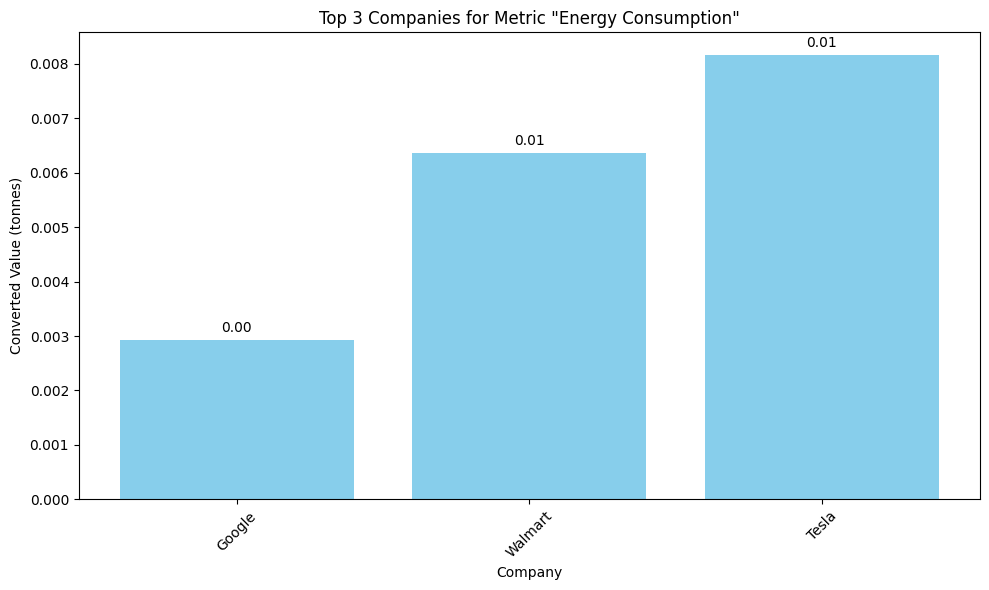

In [17]:
plot_companies(averaged_carbon_emissions_df, 3)

In [18]:
def plot_top_n_metrics(df, desired_metric, N):
    average_df = process_data(desired_metric, df)
    plot_companies(average_df, N)

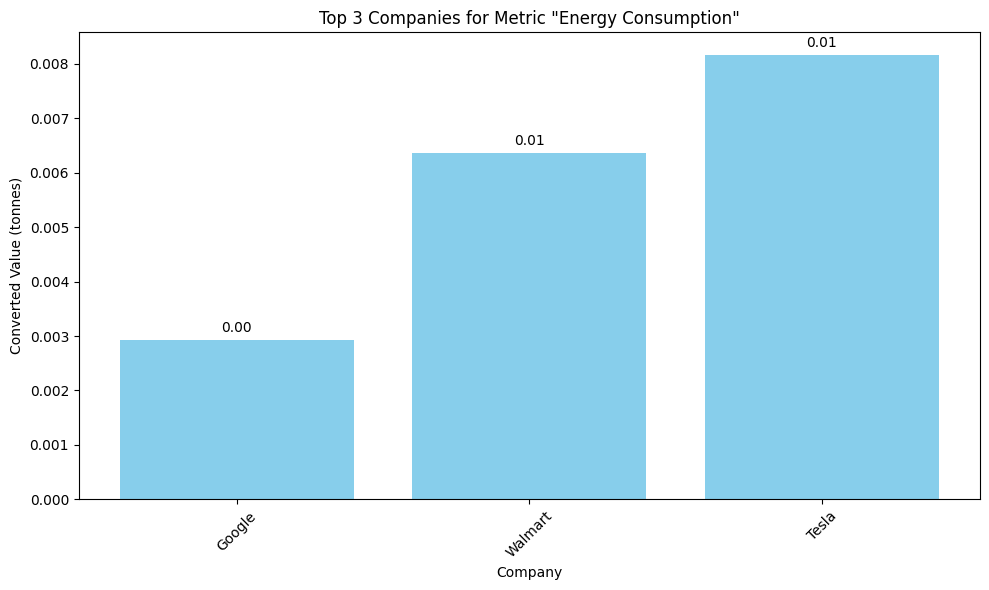

In [19]:
plot_top_n_metrics(df_converted_thomas, "Energy Consumption", 3)

convert_units(df) # must be 'Company', 'Year', 'Metric', 'Value', 'Unit'
plot_top_n_metrics(df, str of metric, Number of plotted)